In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as stat
import numpy as np
import pandas as pd

from __future__ import division

In [2]:
unmodified_pepts_fdr1 = pd.read_pickle("data/unmodified_pept_fdr1.pck")
unmodified_posn_fdr1 = pd.read_pickle("data/unmodified_posn_fdr1.pck")

all_pept_fdr1 = pd.read_pickle("data/all_pept_fdr1.pck")
modified_pept_fdr1 = pd.read_pickle("data/modified_pept_fdr1.pck")

# Figure 2

### Spectrum of mass shifts, pooled across timepoints and replicates

In [3]:
def build_modification_spectrum(pept_df):
    mod_spectrum_by_timepoint_biorep = pept_df.groupby(['MassShift','Time','BiolRep']).count().Index
    all_time_sum_biorep = mod_spectrum_by_timepoint_biorep.unstack().sum(level='MassShift')
    all_time_sum_pooled = mod_spectrum_by_timepoint_biorep.fillna(0).sum(level='MassShift')
    all_time_sum_pooled = all_time_sum_pooled.reindex(index=np.arange(-200,200),fill_value=0)
    all_time_sum_pooled[0] = 0
    return (all_time_sum_biorep,all_time_sum_pooled)

def plot_1D_modification_spectrum(df):
    plt.bar(df.index,df,width=1,linewidth=0)
    ax1 = plt.gca()
    plt.ylabel("Peptide Count", fontsize=36)
    plt.xlabel("Mass Shift (Da)", fontsize=36)
    top5 = df.sort_values(inplace=False).head()
    prettify(ax1,ax_fontsize=20)
    
def prettify(axis,ax_fontsize=None):
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.tick_params(top='off',right='off',which='both')
    if ax_fontsize != None:
        axis.set_yticklabels(axis.get_yticks(),fontsize=ax_fontsize)
        axis.set_xticklabels(axis.get_xticks(),fontsize=ax_fontsize)

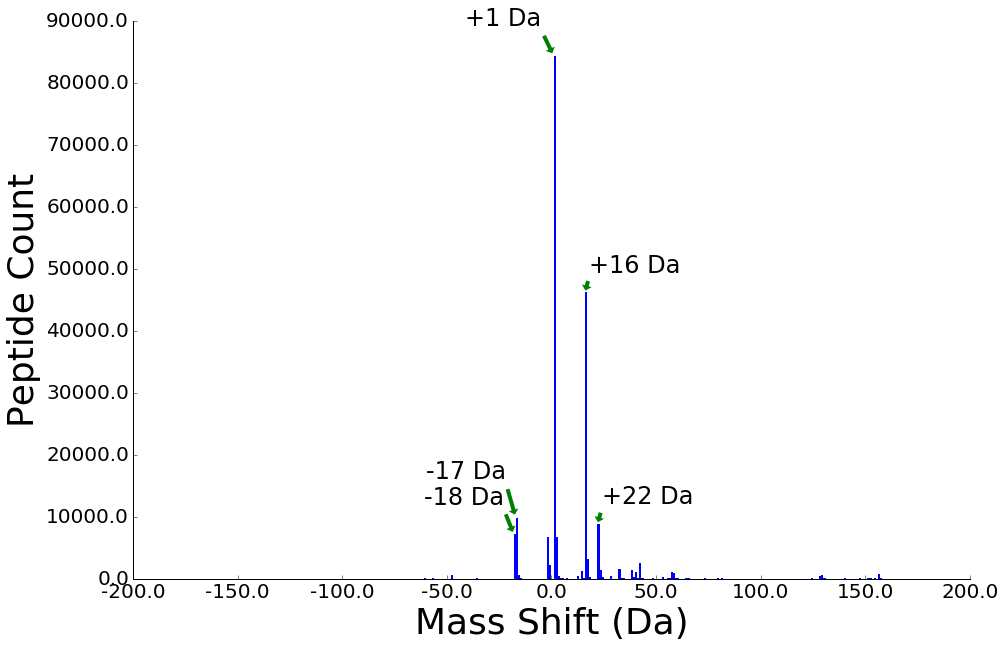

In [4]:
all_pept_fdr1_modspect_biorep, all_pept_fdr1_modspect_pool = build_modification_spectrum(all_pept_fdr1)

plt.gcf().set_figheight(10)
plt.gcf().set_figwidth(15)
plot_1D_modification_spectrum(all_pept_fdr1_modspect_pool)
top5 = all_pept_fdr1_modspect_pool.sort_values(ascending=False,inplace=False).head()
text_offsets = [(-50,30),(50,20),(-50,40),(50,20),(-50,30)]
for (i,(k,v)) in enumerate(top5.iteritems()):
    plt.annotate('{:+d} Da'.format(k),(k,v),
                 xytext=text_offsets[i],
                 textcoords='offset points',
                 arrowprops=dict(facecolor='green',
                                 headlength=5,
                                 headwidth=10,
                                 shrink=0.1,
                                 width=4,
                                 linewidth=0),
                 fontsize=24,
                 horizontalalignment='center')
plt.savefig('figures/FIG_2_all_pept_fdr1_1D_modspectrum.pdf',format='pdf',bbox_inches='tight',pad_inches=0.5)


In [5]:
all_pept_fdr1_modspect_biorep['Mean'] = all_pept_fdr1_modspect_biorep.mean(axis=1)
all_pept_fdr1_modspect_biorep.sort_values(by='Mean',ascending=False,inplace=True)
all_pept_fdr1_modspect_biorep = all_pept_fdr1_modspect_biorep.fillna(0)
all_pept_fdr1_modspect_biorep.to_csv('data/ADDITIONAL_FILE_2_modification_totals_sorted.tsv',sep="\t")

# Figure 9 (Supp. Fig. 1)

### Spectrum of mass shifts, separating biological replicates and timepoints (plot as heatmaps)

In [6]:
def plot_shiftspect_heatmap(spect_df,sort=None,yticks=None):
    if sort:
        spect_df = sort(spect_df)

    spect_df = spect_df.reindex_axis(np.arange(spect_df.index.values.min(),spect_df.index.values.max()))
    plt.imshow(np.log2(spect_df.as_matrix()),interpolation='none',aspect='auto',vmax=16)
    if yticks == None:
        plt.yticks(np.arange(len(spect_df.index)),spect_df.index) 
    else:
        plt.yticks(*yticks)
    plt.xticks(np.arange(len(spect_df.columns)),spect_df.columns)
    
def get_shift_x_time_spectrum(pept_df):
    modspect_time_biorep = pept_df.groupby(['MassShift','Time','BiolRep']).count().Index
    modspect_time_biorep = modspect_time_biorep.unstack()
    modspect_time_biorep = modspect_time_biorep.unstack()
    modspect_time_pool = pept_df.groupby(['MassShift','Time']).count().Index
    modspect_time_pool = modspect_time_pool.unstack()
    return (modspect_time_biorep, modspect_time_pool)

In [7]:
all_pept_fdr1_modspect_time_biorep, all_pept_fdr1_modspect_time_pool = get_shift_x_time_spectrum(all_pept_fdr1)

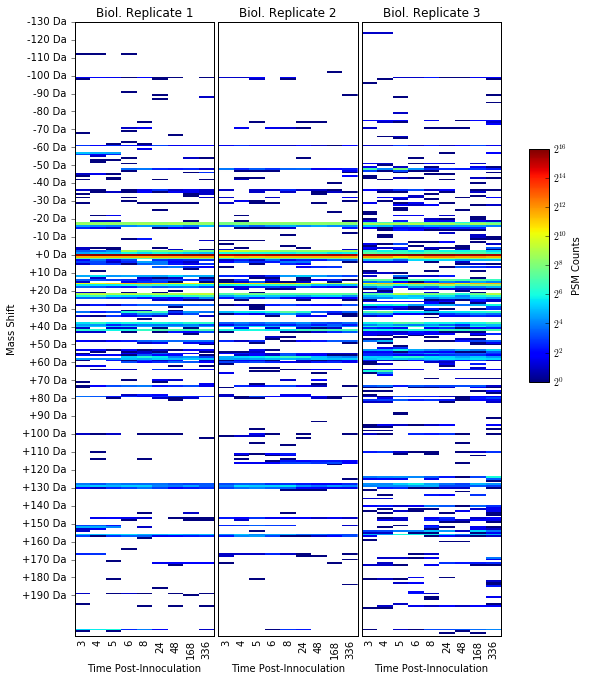

In [8]:
plt.gcf().set_figheight(11)
plt.gcf().set_figwidth(8.5)
biorep=1
plt.subplot2grid((5,20),(0,0),rowspan=5,colspan=6)
plot_shiftspect_heatmap(all_pept_fdr1_modspect_time_biorep[biorep])
ax = plt.gca()
ax.tick_params(axis='both',bottom=False,top=False,right=False)
ax.tick_params(axis='y',direction='out')
plt.yticks(np.arange(-6,324,10),["%d Da" % (x,) for x in np.arange(-130,0,10)] + ["+%d Da" % (x,) for x in np.arange(0,200,10)])
plt.ylabel("Mass Shift")
plt.xlabel("Time Post-Innoculation")
plt.title("Biol. Replicate 1")
ax.set_xticklabels([x.get_text() for x in ax.get_xticklabels()],rotation='vertical')

for biorep in (2,3):
    plt.subplot2grid((5,20),(0,(biorep - 1) * 6),rowspan=5,colspan=6)
    plot_shiftspect_heatmap(all_pept_fdr1_modspect_time_biorep[biorep])
    ax = plt.gca()
    ax.tick_params(axis='both',bottom=False,top=False,left=False,right=False,labelleft=False)
    ax.set_xticklabels([x.get_text() for x in ax.get_xticklabels()],rotation='vertical')
    plt.yticks(np.arange(-6,324,10),np.arange(-130,200,10))
    plt.xlabel("Time Post-Innoculation")
    plt.title("Biol. Replicate %d" % biorep)
cb_ax = plt.subplot2grid((5,20),(1,19),rowspan=2,colspan=1)  

cb = plt.colorbar(cax=cb_ax)#ticks=[(16,14,12,10,8,6,4,2,0),("$2^{16}$","$2^{14}$","$2^{12}$","$2^{10}$","$2^{8}$","$2^{6}$","$2^{4}$","$2^{2}$","$2^{0}$")])
cb.set_ticks((16,14,12,10,8,6,4,2,0))
cb.set_ticklabels(("$2^{16}$","$2^{14}$","$2^{12}$","$2^{10}$","$2^{8}$","$2^{6}$","$2^{4}$","$2^{2}$","$2^{0}$"))
cb.set_label('PSM Counts')
plt.savefig('figures/FIG_S1_spectrum_time_heatmap_fdr1_bioreps.png',format='png')

# Figure 3

### Spectrum of Mass Shifts, separating modified amino acid

In [9]:
def get_shift_x_AA_spectrum(pept_df,uniqpos=False):
    pept_df_biorep = pept_df.copy()
    pept_df_pooled = pept_df.copy()
    #for (aa,mod) in const_AA_mods.items():
    #    pept_df.loc[pept_df['ModifiedResidue'] == aa,'MassShift'] += mod
    if uniqpos:
        #pept_df.loc[pept_df['ModifiedPosition'] > -1,'ModPosn_ProtCoords'] = \
        #    pept_df[pept_df['ModifiedPosition'] > -1]['PeptideStart'] + \
        #    pept_df[pept_df['ModifiedPosition'] > -1]['ModifiedPosition']
        aa_cnt_biorep = pept_df.loc[pept_df['ModifiedPosition'] > -1].groupby(\
            ['MassShift','LocusTag','ModPosn_ProtCoord','ModifiedResidue','BiolRep']).count()['Index']
        pept_df_biorep = aa_cnt_biorep.reset_index()
        aa_cnt_pooled = pept_df.loc[pept_df['ModifiedPosition'] > -1].groupby(\
            ['MassShift','LocusTag','ModPosn_ProtCoord','ModifiedResidue']).count()['Index']
        pept_df_pooled = aa_cnt_pooled.reset_index()

    shift_x_AA_biorep = pept_df_biorep.groupby(['MassShift','ModifiedResidue','BiolRep']).count().LocusTag
    shift_x_AA_biorep = shift_x_AA_biorep.unstack().unstack().fillna(0)
    shift_x_AA_pooled = pept_df_pooled.groupby(['MassShift','ModifiedResidue']).count().LocusTag
    shift_x_AA_pooled = shift_x_AA_pooled.unstack().fillna(0)
    return shift_x_AA_biorep, shift_x_AA_pooled


def sort_singleAA_biorep_cons(in_df):
    all_df = in_df.copy()
    ranks = []
    for i in (1,2,3):
        df = all_df[i]
        print df.shape
        max_ser = df.apply(np.argmax,axis=1)
        nonmax_df = [(ix,x.drop(max_ser[ix])) for (ix,x) in df.iterrows()]
        nonmax_df = pd.DataFrame.from_items(nonmax_df).T.fillna(0)
        df['singleAA_bias'] = (df.max(axis=1)+1) / (nonmax_df.mean(axis=1) + 1)
        ranks.append(df['singleAA_bias'].rank(ascending=False))

    ranks = pd.concat(ranks,axis=1)
    all_df['ranksum'] = ranks.sum(axis=1)
    dfsrt = all_df.sort(axis=0,columns=['ranksum',],inplace=False)
    print dfsrt
    dfsrt = dfsrt.drop(['ranksum'],axis=1)
    return dfsrt


def color_cycle(cmap,N):
    """
    make a color iterator for the given colormap with N levels
    
    cmap: matplotlib.colors.Colormap object
    N: number of colors to cycle

    note that an EndIteration exception will be thrown when all the colors have cycled
    """
    c = 0
    r = np.arange(0,N,dtype=np.float)
    for st in r:
        yield cmap(st/N,1)     

        
def plot_shiftspect_bars_biorep(spect_df,sort=None,showtop=10,col=cm.Dark2,norm=True):
    col_cyc = color_cycle(col,showtop)
    sh_ax = None
    if "-" in spect_df.columns.values:
        spect_df = spect_df.drop(['-'],axis=1)
    if sort:
        spect_df = sort(spect_df)
    for (i,(s,r_all)) in enumerate(spect_df.iloc[:showtop].iterrows()):
            curcol = col_cyc.next()
            for rep in (1,2,3):
                r = r_all[rep]
                if norm:
                    r = r / r.sum()
                if not sh_ax:
                    print (i,s,rep,r,np.arange(spect_df[rep].columns.shape[0]) + rep/3.3)
                    sh_ax = plt.gca()
                    plt.subplot(showtop,1,i+1,sharex=sh_ax)
                    plt.bar(np.arange(spect_df[rep].columns.shape[0]) + rep/3.3,r,width=.25,color=curcol,alpha=rep/3.0,linewidth=0)
                    plt.xticks(np.arange(0.7,len(spect_df[rep].columns)+1.7),spect_df[rep].columns)
                    plt.vlines(np.arange(0,len(spect_df[rep].columns))+1.2,0,1,linestyle=":",color='k',alpha=0.5)
                    sh_ax.set_xticklabels(sh_ax.get_xticklabels(),visible=False)
                    prettify(sh_ax)
                    sh_ax.tick_params(bottom='off',which='both')

                else:
                    plt.subplot(showtop,1,i+1,sharex=sh_ax)
                    plt.bar(np.arange(spect_df[rep].columns.shape[0]) + rep/3.3,r,width=.25,color=curcol,alpha=rep/3.0,linewidth=0)
                    plt.vlines(np.arange(0,len(spect_df[rep].columns))+1.2,0,1,linestyle=":",color='k',alpha=0.5)
                    ax2 = plt.gca()
                    if i <= showtop - 2:
                        ax2.set_xticklabels(sh_ax.get_xticklabels(),visible=False)
                    else:
                        #print sh_ax.get_xticklabels()
                        ax2.set_xticklabels(spect_df[rep].columns,visible=True,fontsize=18)
                        ax2.set_xlabel("Modified Amino Acid",fontsize=24)
                    prettify(ax2)
                    ax2.tick_params(bottom='off',which='both')
                plt.ylabel('{:+d} Da'.format(s),rotation=0,verticalalignment='center',horizontalalignment='right',fontsize=18)
            plt.ylim(0,1.1)
            plt.yticks([0,1])
        


In [10]:
all_pept_fdr1_modspect_AA_biorep, all_pept_fdr1_modspect_AA_pool = get_shift_x_AA_spectrum(all_pept_fdr1)
all_pept_fdr1_modspect_AA_biorep_uniqpos, all_pept_fdr1_modspect_AA_pool_uniqpos = get_shift_x_AA_spectrum(all_pept_fdr1,uniqpos=True)
print all_pept_fdr1_modspect_AA_pool['R'].head()
print all_pept_fdr1_modspect_AA_pool_uniqpos.head()

MassShift
-124     0.0
-112     0.0
-102     0.0
-99     47.0
-98      7.0
Name: R, dtype: float64
ModifiedResidue    A    C    D    E    F    G    H    I    K    L    M    N  \
MassShift                                                                     
-124             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
-112             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
-102             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
-99              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
-98              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

ModifiedResidue    P    Q    R    S    T    V    W    Y  
MassShift                                                
-124             0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  
-112             0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
-102             0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
-99              0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  

In [11]:
all_pept_fdr1_modspect_AA_biorep, all_pept_fdr1_modspect_AA_pool = get_shift_x_AA_spectrum(all_pept_fdr1)
all_pept_fdr1_modspect_AA_biorep_uniqpos, all_pept_fdr1_modspect_AA_pool_uniqpos = get_shift_x_AA_spectrum(all_pept_fdr1,uniqpos=True)
print all_pept_fdr1_modspect_AA_biorep.loc[slice(None),(slice(None),'R')].head()
print all_pept_fdr1_modspect_AA_biorep_uniqpos.head()
print all_pept_fdr1[all_pept_fdr1.MassShift == -99]
print unmodified_posn_fdr1.loc[(slice(None),'rplE',71),slice(None)].sum()

BiolRep             1     2     3
ModifiedResidue     R     R     R
MassShift                        
-124              0.0   0.0   0.0
-112              0.0   0.0   0.0
-102              0.0   0.0   0.0
-99              18.0  11.0  18.0
-98               2.0   3.0   2.0
BiolRep            1                                              ...     3  \
ModifiedResidue    A    C    D    E    F    G    H    I    K    L ...     M   
MassShift                                                         ...         
-124             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
-112             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
-102             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
-99              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
-98              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   

BiolRep                                                       
ModifiedResidue    N    P    Q  

(230, 20)


/Users/barricklab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(230, 20)
(230, 20)


/Users/barricklab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:36: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


BiolRep             1                                                         \
ModifiedResidue     A      C     D     E     F     G     H     I     K     L   
MassShift                                                                      
 58               0.0  121.0   0.0   0.0   2.0   4.0   0.0   0.0   1.0   1.0   
 40               0.0   26.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   
 16              51.0    1.0  24.0  34.0   8.0  65.0  17.0  17.0  14.0  35.0   
 32               2.0    0.0   1.0   3.0   1.0   2.0   0.0   1.0   0.0   0.0   
 59               2.0   14.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   1.0   
 79               0.0   15.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
 17               8.0    0.0   3.0   8.0   3.0  18.0   3.0   2.0   1.0   9.0   
-48               0.0    0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0   
 209              0.0   32.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
 73               0.0    7.0   0.0   0.0

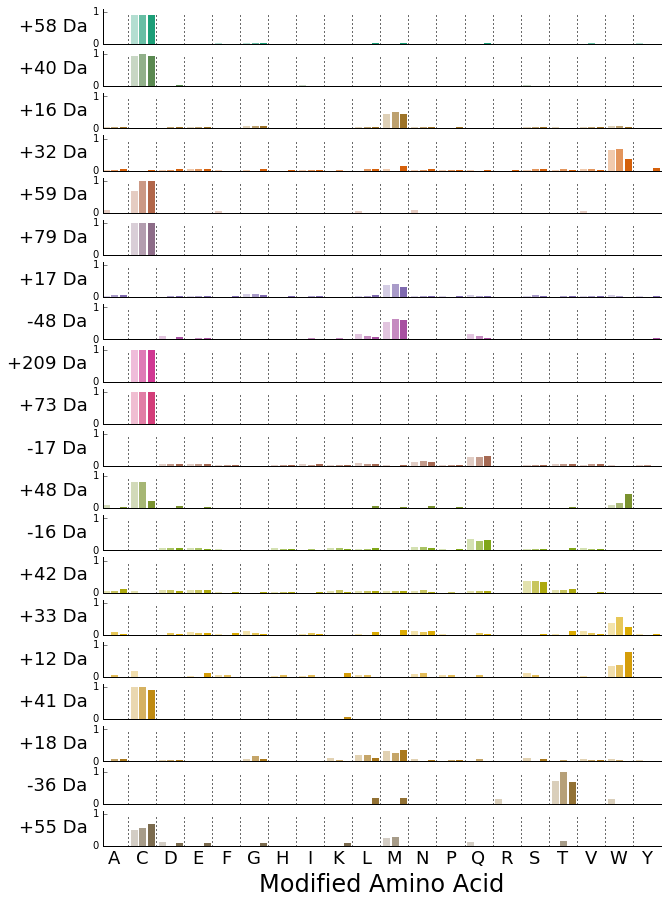

In [12]:
plt.gcf().set_figheight(15)
plt.gcf().set_figwidth(10)

plot_shiftspect_bars_biorep(all_pept_fdr1_modspect_AA_biorep_uniqpos,showtop=20,sort=sort_singleAA_biorep_cons)
plt.savefig('figures/FIG_3_all_pept_fdr1_modspect_AA_pool_uniqpos_AAdist_bars_biorep.pdf',format='pdf',bbox_inches='tight',pad_inches=0.5)

In [13]:
all_pept_fdr1_modspect_AA_biorep_suptab = all_pept_fdr1_modspect_AA_biorep_uniqpos.stack('ModifiedResidue').stack('BiolRep').unstack('ModifiedResidue').unstack('BiolRep')
all_pept_fdr1_modspect_AA_biorep_suptab.to_csv("data/ADDITIONAL_FILE_3_mass_shifts_by_AA.tsv", sep='\t')

In [14]:
all_pept_fdr1_AA_sum_ser = all_pept_fdr1_modspect_AA_pool.sum(axis=0).sort(inplace=False,ascending=False).drop("-")

all_pept_fdr1_AA_sum = pd.DataFrame(data={'Modified PSMs':all_pept_fdr1_AA_sum_ser.apply(np.int),
                                          'Percentage':(all_pept_fdr1_AA_sum_ser / all_pept_fdr1_AA_sum_ser.sum())*100})

all_pept_fdr1_AA_sum.to_csv("data/TABLE_3_all_pept_fdr1_AA_sum_tab.tsv",sep="\t")

/Users/barricklab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  if __name__ == '__main__':


# Figures 4 & 5

### Spectrum of Mass shifts, separating position bins along protein Nt->Ct length

In [15]:
def position_hist(df,draw=True,bins=10,uniqpepts=False):
    outhist = None
    locn_arr = None
    if uniqpepts:
        locn_cnt = df.loc[df['ModifiedPosition'] > -1].groupby(['LocusTag','ModPosn_ProtFract']).count()['Index']
        locn_cnt = locn_cnt.reset_index()
        locn_arr = locn_cnt['ModPosn_ProtFract']
    else:
        locn_arr = np.array(df.loc[df['ModifiedPosition'] > -1,'ModPosn_ProtFract'])
    outhist = np.histogram(locn_arr,bins=np.linspace(0.0,1.0,num=bins))
    return outhist

def get_shift_x_seq_posn_bin_spectrum(pept_df, bins=20, uniqpepts=False):
    pept_df = pept_df.copy()
    pept_df.loc[pept_df['ModifiedPosition'] > -1,'ModPosn_ProtCoords'] = \
        pept_df[pept_df['ModifiedPosition'] > -1]['PeptideStart'] + \
        pept_df[pept_df['ModifiedPosition'] > -1]['ModifiedPosition']
    pept_df.loc[pept_df['ModifiedPosition'] > -1,'ModPosn_ProtFract'] = \
        pept_df[pept_df['ModifiedPosition'] > -1]['ModPosn_ProtCoords'] / \
        pept_df[pept_df['ModifiedPosition'] > -1]['Length']
    pept_df = pept_df.fillna(0)
    shift_x_seq_posn_bin_df = \
        pd.DataFrame.from_dict(dict([(x,position_hist(pept_df[pept_df['MassShift'] == x], \
                                                      draw=False,bins=bins,uniqpepts=uniqpepts)[0]) \
                                     for x in np.arange(-200,200) \
                                     if (x != 0) and \
                                     (pept_df[pept_df['MassShift'] == x].shape[0] > 1)])).T
    return shift_x_seq_posn_bin_df

def get_shift_x_seq_posn(pept_df, bins=20, uniqpepts=False):
    pept_df = pept_df.copy()
    pept_df.loc[pept_df['ModifiedPosition'] > -1,'ModPosn_ProtCoords'] = \
        (pept_df[pept_df['ModifiedPosition'] > -1]['PeptideStart'] + \
         pept_df[pept_df['ModifiedPosition'] > -1]['ModifiedPosition']) - 2
    pept_df.loc[pept_df['ModifiedPosition'] > -1,'ModPosn_ProtFract'] = \
        pept_df[pept_df['ModifiedPosition'] > -1]['ModPosn_ProtCoords'] / \
        pept_df[pept_df['ModifiedPosition'] > -1]['Length']
    pept_df = pept_df.fillna(0)
    shift_x_seq_posn = pept_df.groupby(['MassShift','LocusTag','ModPosn_ProtFract']).count()['ModifiedPosition']
    print shift_x_seq_posn
    shift_x_seq_posn_medians = shift_x_seq_posn.reset_index().groupby(['MassShift']).median()['ModPosn_ProtFract']
    return shift_x_seq_posn,shift_x_seq_posn_medians

def shift_x_seq_KS_pvals(seq_fract_ser):
    seq_fract_ser_nocnt = seq_fract_ser.reset_index().groupby(['MassShift'])['ModPosn_ProtFract']
    shift_x_seq_KS = seq_fract_ser_nocnt.aggregate((lambda x: stat.ks_2samp(x,seq_fract_ser)[1]))
    shift_x_seq_ttest = seq_fract_ser_nocnt.aggregate((lambda x: stat.ttest_ind(x,seq_fract_ser)[1]))
    print shift_x_seq_KS
    print shift_x_seq_ttest
    return shift_x_seq_ttest

def seq_posn_stripplot(shift_x_seq_posn,shifts,col=cm.Dark2,marker='x',show_hist=True):   
    tlocs = []
    tlabs = []
    ymax = len(shifts)
    col_cyc = color_cycle(col,ymax)
    xmax = None
    xmin = None
    for (i,shift) in enumerate(shifts):
        shift_posns = shift_x_seq_posn[shift].reset_index()['ModPosn_ProtFract']
        y_posn = ymax - (i+.5)
        y_vals = np.empty(shift_posns.shape[0])
        y_vals.fill(y_posn)
        shift_col = col_cyc.next()
        #print shift_posns
        if marker != None:
            plt.plot(shift_posns,y_vals,marker=marker,markeredgewidth=1,linewidth=0,color=shift_col,label='{:+d} Da'.format(shift))
        if show_hist:
            (shift_hist, shift_bins) = np.histogram(shift_posns,density=True,bins=np.linspace(0,1,50))
            shift_hist = 0.5 * (shift_hist / shift_hist.max())
            shift_bins = (shift_bins[:-1] + shift_bins[1:]) / 2
            plt.fill_between(shift_bins,np.array([y_posn,]*shift_hist.shape[0]) + \
                             shift_hist,np.array([y_posn,]*shift_hist.shape[0]) - \
                             shift_hist,color=shift_col,alpha=0.3)
        plt.hlines(ymax - (i+.5),shift_bins.min(),shift_bins.max(),colors='k',linestyles='dotted',alpha=0.5)
        xmax = shift_bins.max()
        xmin = shift_bins.min()
        tlocs.append(ymax - (i+.5))
        tlabs.append('{:+d} Da'.format(shift))
    
    plt.ylim(0,ymax)
    plt.xlim(-0.1,1.1)
    plt.yticks(tlocs,tlabs)
    plt.xticks(np.linspace(xmin,xmax,num=5),np.linspace(0,100,num=5))
    plt.ylabel('Mass Shift')
    plt.xlabel('Percent Protein Length')

def shift_x_seq_posn_stripplot(pept_df,sort=None,showtop=10,col=cm.Dark2,marker='x',show_hist=True):
    col_cyc = color_cycle(col,showtop)
    sh_ax = None
    shift_x_seq_posn,shift_x_seq_posn_medians = get_shift_x_seq_posn(pept_df)
    shift_x_seq_posn_bin20 = get_shift_x_seq_posn_bin_spectrum(pept_df,20)
    if sort:
        shift_x_seq_posn_bin20 = sort(shift_x_seq_posn_bin20)
    shift_x_seq_posn_topN = shift_x_seq_posn_bin20[:showtop]
    tlocs = []
    tlabs = []
    for (i,shift) in enumerate(shift_x_seq_posn_topN.index.values):
        shift_posns = shift_x_seq_posn[shift].reset_index()['ModPosn_ProtFract']
        y_posn = showtop - (i+.5)
        y_vals = np.empty(shift_posns.shape[0])
        y_vals.fill(y_posn)
        shift_col = col_cyc.next()
        plt.plot(shift_posns,y_vals,marker=marker,markeredgewidth=1,linewidth=0,color=shift_col,label='{:+d} Da'.format(shift))
        (shift_hist, shift_bins) = np.histogram(shift_posns,density=True,bins=np.linspace(0,1,50))
        shift_hist = 0.5 * (shift_hist / shift_hist.max())
        plt.fill_between(shift_bins[:-1],np.array([y_posn,]*shift_hist.shape[0]) + \
                         shift_hist,np.array([y_posn,]*shift_hist.shape[0]) - \
                         shift_hist,color=shift_col,alpha=0.3)
        plt.hlines(showtop - (i+.5),0,1,colors='k',linestyles='dotted',alpha=0.5)
        tlocs.append(showtop - (i+.5))
        tlabs.append('{:+d} Da'.format(shift))
    
    plt.ylim(0,showtop)
    plt.xlim(-0.1,1.1)
    plt.yticks(tlocs,tlabs)
    plt.xticks(np.linspace(0,1,num=5),np.linspace(0,100,num=5))
    plt.ylabel('Mass Shift')
    plt.xlabel('Percent Protein Length')

def sort_posnhist_Nterm(df):
    df = df.copy()
    df['Nt_bias'] = (df[0]+1) / (df.iloc[:,1:].mean(axis=1)+1)
    dfsrt = df.sort(axis=0,columns=['Nt_bias',],inplace=False,ascending=False)
    dfsrt = dfsrt.drop('Nt_bias',axis=1)
    return dfsrt

def sort_posnhist_Cterm(df):
    df = df.copy()
    df['Ct_bias'] = (df.iloc[:,-1]+1) / (df.iloc[:,:-1].mean(axis=1)+1)
    dfsrt = df.sort(axis=0,columns=['Ct_bias',],inplace=False,ascending=False)
    dfsrt = dfsrt.drop('Ct_bias',axis=1)
    return dfsrt
        

### Fisher's exact test for Nt / Ct modification

In [16]:
def prot_posn_FET(mod_pept_df,unmod_posn_df,test_alt='two-sided'):
    mod_df = mod_pept_df.copy()
    unmod_df = unmod_posn_df.copy()

    mod_nt_locus_grp = mod_df[mod_df['ModPosn_ProtCoord'] <= 2].groupby(\
                        ['LocusTag','Locus','ModPosn_ProtCoord',\
                         'ModifiedResidue','MassShift','BiolRep']).count()['Index'].unstack('BiolRep').fillna(0)
    mod_nonnt_locus_grp = mod_df[mod_df['ModPosn_ProtCoord'] > 2].groupby(\
                        ['LocusTag','Locus','ModPosn_ProtCoord',\
                         'ModifiedResidue','MassShift','BiolRep']).count()['Index'].unstack('BiolRep').fillna(0)
    unmod_nt_posns = unmod_posn_df.reindex_axis(mod_nt_locus_grp.index,method='ffill').sum(level='BiolRep',axis=1)
    unmod_nonnt_posns = unmod_posn_df.reindex_axis(mod_nonnt_locus_grp.index,method='ffill').sum(level='BiolRep',axis=1)
    print unmod_nonnt_posns
    
    mod_ct_locus_grp = mod_df[mod_df['ModPosn_ProtCoord'] == mod_df['Length']].groupby(\
                        ['LocusTag','Locus','ModPosn_ProtCoord',\
                         'ModifiedResidue','MassShift','BiolRep']).count()['Index'].unstack('BiolRep').fillna(0)
    mod_nonct_locus_grp = mod_df[mod_df['ModPosn_ProtCoord'] < mod_df['Length']].groupby(\
                        ['LocusTag','Locus','ModPosn_ProtCoord',\
                         'ModifiedResidue','MassShift','BiolRep']).count()['Index'].unstack('BiolRep').fillna(0)
    unmod_ct_posns = unmod_posn_df.reindex_axis(mod_ct_locus_grp.index,method='ffill').sum(level='BiolRep',axis=1)
    unmod_nonct_posns = unmod_posn_df.reindex_axis(mod_nonct_locus_grp.index,method='ffill').sum(level='BiolRep',axis=1)
    print unmod_nonct_posns
    
    nt_mod_FET = pd.DataFrame(index=pd.Index(np.arange(-200,200)),\
                              columns=pd.MultiIndex.from_product([[1,2,3],\
                                                                  ['modNt','modNonNt','unmodNt','unmodNonNt','logodds_score','pValue']],\
                                                                  sortorder=0,names=['BiolRep','PeptCounts'])).sort_index().fillna(0)
    ct_mod_FET = pd.DataFrame(index=pd.Index(np.arange(-200,200)),\
                              columns=pd.MultiIndex.from_product([[1,2,3],\
                                                                  ['modCt','modNonCt','unmodCt','unmodNonCt','logodds_score','pValue']],\
                                                                 sortorder=0,names=['BiolRep','PeptCounts'])).sort_index().fillna(0)
    
    #print mod_nt_locus_grp.head()
    print mod_nt_locus_grp.sum(level='MassShift').reindex_axis(nt_mod_FET.index)
    print nt_mod_FET.loc[slice(None),(slice(None),'modNt')].head()
    
    nt_mod_FET.loc[slice(None),(slice(None),'modNt')] += mod_nt_locus_grp.sum(level=['MassShift']).reindex_axis(nt_mod_FET.index)
    nt_mod_FET.loc[slice(None),(slice(None),'modNonNt')] += mod_nonnt_locus_grp.sum(level='MassShift').reindex_axis(nt_mod_FET.index)
    nt_mod_FET.loc[slice(None),(slice(None),'unmodNt')] += unmod_nt_posns.sum(level='MassShift').reindex_axis(nt_mod_FET.index)
    nt_mod_FET.loc[slice(None),(slice(None),'unmodNonNt')] += unmod_nonnt_posns.sum(level='MassShift').reindex_axis(nt_mod_FET.index)
    
    ct_mod_FET.loc[slice(None),(slice(None),'modCt')] += mod_ct_locus_grp.sum(level='MassShift').reindex_axis(ct_mod_FET.index)
    ct_mod_FET.loc[slice(None),(slice(None),'modNonCt')] += mod_nonct_locus_grp.sum(level='MassShift').reindex_axis(ct_mod_FET.index)
    ct_mod_FET.loc[slice(None),(slice(None),'unmodCt')] += unmod_ct_posns.sum(level='MassShift').reindex_axis(ct_mod_FET.index)
    ct_mod_FET.loc[slice(None),(slice(None),'unmodNonCt')] += unmod_nonct_posns.sum(level='MassShift').reindex_axis(ct_mod_FET.index)
    
    nt_mod_FET.fillna(0,inplace=True)
    ct_mod_FET.fillna(0,inplace=True)
    
    for i in (1,2,3):
        print nt_mod_FET[i]
        nt_mod_FET.loc[slice(None),(i,'logodds_score')] = \
            nt_mod_FET[i].apply((lambda x:stat.fisher_exact(\
                np.array([[x['modNt'],x['unmodNt']],[x['modNonNt'],x['unmodNonNt']]]),\
                                                            alternative=test_alt)[0]),axis=1)
            
        nt_mod_FET.loc[slice(None),(i,'pValue')] = \
            nt_mod_FET[i].apply((lambda x:stat.fisher_exact(\
                np.array([[x['modNt'],x['unmodNt']],[x['modNonNt'],x['unmodNonNt']]]),\
                                                            alternative=test_alt)[1]),axis=1)
          
        ct_mod_FET.loc[slice(None),(i,'logodds_score')] = \
            ct_mod_FET[i].apply((lambda x:stat.fisher_exact(\
                np.array([[x['modCt'],x['unmodCt']],[x['modNonCt'],x['unmodNonCt']]]),\
                                                            alternative=test_alt)[0]),axis=1)
        ct_mod_FET.loc[slice(None),(i,'pValue')] = \
            ct_mod_FET[i].apply((lambda x:stat.fisher_exact(\
                np.array([[x['modCt'],x['unmodCt']],[x['modNonCt'],x['unmodNonCt']]]),\
                                                            alternative=test_alt)[1]),axis=1)


    return nt_mod_FET,ct_mod_FET
    

In [17]:
(nt_FET,ct_FET) = prot_posn_FET(modified_pept_fdr1,unmodified_posn_fdr1)

# Filter pValues; make sure that all logodds scores are in the same direction
nt_FET_cons = nt_FET[((nt_FET.loc[slice(None),(1,'pValue')] < 0.05) &
                      ((nt_FET.loc[slice(None),(2,'pValue')] < 0.05) &
                       (nt_FET.loc[slice(None),(3,'pValue')] < 0.05))) &
                     (((nt_FET.loc[slice(None),(1,'logodds_score')] < 1) &
                       ((nt_FET.loc[slice(None),(2,'logodds_score')] < 1) &
                        (nt_FET.loc[slice(None),(3,'logodds_score')] < 1))) |
                      ((nt_FET.loc[slice(None),(1,'logodds_score')] > 1) &
                       ((nt_FET.loc[slice(None),(2,'logodds_score')] > 1) &
                        (nt_FET.loc[slice(None),(3,'logodds_score')] > 1))))]

ct_FET_cons = ct_FET[(ct_FET.loc[slice(None),(1,'pValue')] < 0.05) &
                     ((ct_FET.loc[slice(None),(2,'pValue')] < 0.05) &
                      (ct_FET.loc[slice(None),(3,'pValue')] < 0.05))&
                     (((ct_FET.loc[slice(None),(1,'logodds_score')] < 1) &
                       ((ct_FET.loc[slice(None),(2,'logodds_score')] < 1) &
                        (ct_FET.loc[slice(None),(3,'logodds_score')] < 1))) |
                      ((ct_FET.loc[slice(None),(1,'logodds_score')] > 1) &
                       ((ct_FET.loc[slice(None),(2,'logodds_score')] > 1) &
                        (ct_FET.loc[slice(None),(3,'logodds_score')] > 1))))]

nt_FET_cons_srt = nt_FET_cons.copy()
ct_FET_cons_srt = ct_FET_cons.copy()

print ct_FET_cons_srt

nt_FET_cons_srt[('mean_pval','')] = nt_FET_cons_srt.loc[:,(slice(None),'pValue')].mean(axis=1)
ct_FET_cons_srt[('mean_pval','')] = ct_FET_cons_srt.loc[:,(slice(None),'pValue')].mean(axis=1)

nt_FET_cons_srt.sort(columns=[('mean_pval','')],inplace=True)
ct_FET_cons_srt.sort(columns=[('mean_pval','')],inplace=True)

nt_FET_cons = nt_FET_cons_srt.drop(('mean_pval',''),axis=1)
ct_FET_cons = ct_FET_cons_srt.drop(('mean_pval',''),axis=1)

print nt_FET_cons
print ct_FET_cons

BiolRep                                                          1      2  \
LocusTag  Locus ModPosn_ProtCoord ModifiedResidue MassShift                 
ECB_00002 thrA  32                Q               -17          0.0    0.0   
                70                I                28         37.0   45.0   
                                                   29         37.0   45.0   
                                                   124        37.0   45.0   
                                                   125        37.0   45.0   
                76                T                125        37.0   45.0   
                77                G                22         37.0   45.0   
                78                L                38         37.0   45.0   
                80                A                22         37.0   45.0   
                81                A                1          36.0   45.0   
                                                   22         36.0   45.0   

/Users/barricklab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/barricklab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


### Generate formatted Nt & Ct enrichment tables (Tables 4 & 5)

In [18]:
def build_NtCtFE_pval_table(NtFET_df, CtFET_df):
    Nt_df = NtFET_df.stack('BiolRep')
    Ct_df = CtFET_df.stack('BiolRep')
    #FE_pval_biorep_idx = pd.MultiIndex.from_product([FE_df.index.values,[1,2,3]],sortorder=0,names=['MassShift','Replicate'])
    Nt_FE_pval_biorep = pd.DataFrame(index=Nt_df.index,columns=['N-terminal','Non-N-Terminal','pValue'])
    Ct_FE_pval_biorep = pd.DataFrame(index=Ct_df.index,columns=['C-terminal','Non-C-Terminal','pValue'])
    
    for (idx, r) in Nt_df.iterrows():
        nt_modified = Nt_df.loc[idx,'modNt']
        nt_total = Nt_df.loc[idx,'modNt'] + Nt_df.loc[idx,'unmodNt']
        nt_pct = (nt_modified / nt_total) * 100
        
        nonnt_modified = Nt_df.loc[idx,'modNonNt']
        nonnt_total = Nt_df.loc[idx,'modNonNt'] + Nt_df.loc[idx,'unmodNonNt']
        nonnt_pct = (nonnt_modified / nonnt_total) * 100
        
        Nt_FE_pval_biorep.loc[idx,'pValue'] = "%.2e" % (Nt_df.loc[idx,'pValue'],)
        Nt_FE_pval_biorep.loc[idx,'N-terminal'] = "%d/%d (%.2f%%)" % (nt_modified,nt_total,nt_pct)
        Nt_FE_pval_biorep.loc[idx,'Non-N-Terminal'] = "%d/%d (%.2f%%)" % (nonnt_modified,nonnt_total,nonnt_pct)

    for (idx, r) in Ct_df.iterrows():
        ct_modified = Ct_df.loc[idx,'modCt']
        ct_total = Ct_df.loc[idx,'modCt'] + Ct_df.loc[idx,'unmodCt']
        ct_pct = (ct_modified / ct_total) * 100
        
        nonct_modified = Ct_df.loc[idx,'modNonCt']
        nonct_total = Ct_df.loc[idx,'modNonCt'] + Ct_df.loc[idx,'unmodNonCt']
        nonct_pct = (nonct_modified / nonct_total) * 100
        
        Ct_FE_pval_biorep.loc[idx,'pValue'] = "%.2e" % (Ct_df.loc[idx,'pValue'],)
        Ct_FE_pval_biorep.loc[idx,'C-terminal'] = "%d/%d (%.2f%%)" % (ct_modified,ct_total,ct_pct)
        Ct_FE_pval_biorep.loc[idx,'Non-C-Terminal'] = "%d/%d (%.2f%%)" % (nonct_modified,nonct_total,nonct_pct)

    return Nt_FE_pval_biorep, Ct_FE_pval_biorep

In [19]:
nt_FET_table, ct_FET_table = build_NtCtFE_pval_table(nt_FET_cons, ct_FET_cons)
nt_FET_table.to_csv('data/TABLE_4_Nt_FET_MassShifts_table.tsv',sep='\t')
ct_FET_table.to_csv('data/TABLE_5_Ct_FET_MassShifts_table.tsv',sep='\t')


MassShift  LocusTag   ModPosn_ProtFract
-124       ECB_03708   0.374502             1
                       0.419655             3
-112       ECB_01774   0.589333             3
-102       ECB_04157   0.923773             1
-99        ECB_03159   0.385475            39
           ECB_03856   0.144670             8
-98        ECB_03159   0.385475             7
-96        ECB_03269   0.595985             1
-91        ECB_03406   0.571429             1
-89        ECB_00183   0.009404             1
           ECB_01048   0.016129             1
           ECB_02449   0.298842             1
-88        ECB_00911   0.008287             2
           ECB_03616   0.863043             1
-87        ECB_01517   0.571429             1
-85        ECB_03035   0.647191             1
-79        ECB_02231   0.501946             2
-75        ECB_03191   0.359375            24
-74        ECB_01301  -0.005952             1
           ECB_02542  -0.005848             4
           ECB_03191   0.359375         

/Users/barricklab/anaconda/lib/python2.7/site-packages/pandas/indexes/multi.py:610: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_value(s, k)


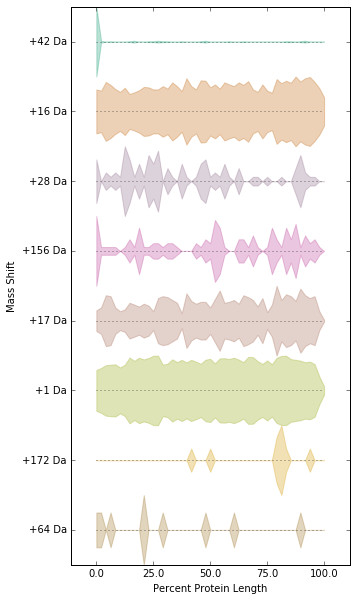

In [20]:
plt.gcf().set_figheight(10)
plt.gcf().set_figwidth(5)
all_pept_fdr1_shift_x_seq_posn,all_pept_fdr1_shift_x_seq_posn_medians = get_shift_x_seq_posn(all_pept_fdr1)
seq_posn_stripplot(all_pept_fdr1_shift_x_seq_posn,nt_FET_cons.index.values,marker=None)
plt.savefig('figures/FIG_4_all_pept_fdr1_modspect_all_pept_Ntbias_stripplot_sigFET.pdf',format='pdf',bbox_inches='tight',pad_inches=0.5)

MassShift  LocusTag   ModPosn_ProtFract
-124       ECB_03708   0.374502             1
                       0.419655             3
-112       ECB_01774   0.589333             3
-102       ECB_04157   0.923773             1
-99        ECB_03159   0.385475            39
           ECB_03856   0.144670             8
-98        ECB_03159   0.385475             7
-96        ECB_03269   0.595985             1
-91        ECB_03406   0.571429             1
-89        ECB_00183   0.009404             1
           ECB_01048   0.016129             1
           ECB_02449   0.298842             1
-88        ECB_00911   0.008287             2
           ECB_03616   0.863043             1
-87        ECB_01517   0.571429             1
-85        ECB_03035   0.647191             1
-79        ECB_02231   0.501946             2
-75        ECB_03191   0.359375            24
-74        ECB_01301  -0.005952             1
           ECB_02542  -0.005848             4
           ECB_03191   0.359375         

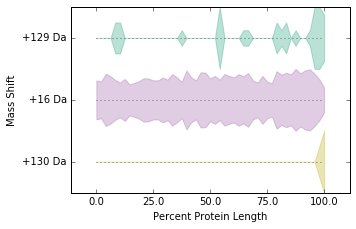

In [21]:
plt.gcf().set_figheight(3.33)
plt.gcf().set_figwidth(5)
all_pept_fdr1_shift_x_seq_posn,all_pept_fdr1_shift_x_seq_posn_medians = get_shift_x_seq_posn(all_pept_fdr1)
seq_posn_stripplot(all_pept_fdr1_shift_x_seq_posn,ct_FET_cons.index.values,marker=None)
plt.savefig('figures/FIG_5_all_pept_fdr1_modspect_all_pept_Ctbias_stripplot_sigFET.pdf',format='pdf',bbox_inches='tight',pad_inches=0.5)